# Pricing Options using Trinomial Trees and Monte Carlo Simulation
## followed by other applications (Delta Hedging, Option "Greeks", Implied Volatility)
## Zach Barnhart

### First we copy all our results from the first part, since we will build on these classes

## StockOption base class

In [1]:
import math

# The basic stock option class that will serve as the basis for more specific subclasses
# Contains all the basic attibutes and methods common to all options
class StockOption(object):
    def __init__(self, s_0, K, r=0.04, T=1, N=2, pu=0, pd=0, div=0, sigma=0, is_put=False, is_am=False):
        """
        Initialize the stock option base class.
        Defaults to European call unless specified.

        :param s_0: initial stock price
        :param K: strike price
        :param r: risk-free rate
        :param T: time to expiration
        :param N: number of time steps
        :param pu: percentage increase in up state
        :param pd: percentage increase in down state
        :param div: Dividend yield (we don't use this year, but we will in future papers)
        :param is_put: True for a put option, False for a call option
        :param is_am: True for an American option, False for a European option
        """
        
        self.s_0 = s_0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1, N)
        self.STs = [] # Declare the stock prices tree

        """ Optional parameters used by derived classes """
        self.pu, self.pd = pu, pd
        self.div = div
        self.sigma = sigma
        self.is_call = not is_put
        self.is_european = not is_am

    @property
    def dt(self):
        """ Single time step, in years """
        return self.T / float(self.N)

    @property
    def df(self):
        """ The discount factor """
        return math.exp(-(self.r-self.div)*self.dt)  

## European options using a binomial tree

In [2]:
import numpy as np
from decimal import Decimal

# Price a basic European option using the binomial tree model 
class BinomialEuropeanOption(StockOption):

    def setup_parameters(self):
        # Required calculations for the model
        self.M = self.N + 1  # Number of terminal nodes of tree
        self.u = 1 + self.pu  # Expected value in the up state
        self.d = 1 - self.pd  # Expected value in the down state
        self.qu = (math.exp((self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
        self.qd = 1 - self.qu

    def init_underlying_price_tree(self):
        # Initialize terminal price nodes to zeros
        self.STs = np.zeros(self.M)

        # Calculate expected stock prices for each node
        for i in range(self.M):
            self.STs[i] = self.s_0 * (self.u**(self.N-i)) * (self.d**i)

    def init_payoffs_tree(self):
        """
        Returns the payoffs when the option expires at terminal nodes
        """ 
        if self.is_call:
            return np.maximum(0, self.STs - self.K)
        else:
            return np.maximum(0, self.K - self.STs)

    def calculate_payoffs(self, payoffs):
        """
        Starting from the time the option expires, traverse backwards and calculate discounted payoffs at each node
        """
        for i in range(self.N):
            payoffs = (payoffs[:-1] * self.qu + payoffs[1:] * self.qd) * self.df

        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.calculate_payoffs(payoffs)

    def price(self):
        """ Entry point of the pricing implementation """
        self.setup_parameters()
        self.init_underlying_price_tree()
        payoffs = self.begin_tree_traversal()

        # Option value converges to first node
        return payoffs[0]

In [3]:
BinomialEuropeanOption(30, 55, r=0.04, T=2, N=2, pu=0.2, pd=0.2, is_put=True).price()

20.771399051264964

## American options using a binomial tree
### (Class can handle both types)

In [42]:
#Price a European or American option by the binomial tree 

class BinomialTreeOption(StockOption):

    def setup_parameters(self):
        self.u = 1 + self.pu  # Expected value in the up state
        self.d = 1 - self.pd  # Expected value in the down state
        self.qu = (math.exp((self.r - self.div) *  self.dt) - self.d) / (self.u - self.d)
        self.qd = 1 - self.qu

    def init_underlying_price_tree(self):
        # Initialize a tree to add to
        self.STs = [np.array([self.s_0])]

        # Simulate the possible stock prices path
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate((prev_branches * self.u, [prev_branches[-1] * self.d]))
            self.STs.append(st) # Add nodes at each time step

    def init_payoffs_tree(self):
        if self.is_call:
            return np.maximum(0, self.STs[self.N] - self.K)
        else:
            return np.maximum(0, self.K - self.STs[self.N])

    def check_early_exercise(self, payoffs, node):
        if self.is_call:
            return np.maximum(payoffs, self.STs[node] - self.K)
        else:
            return np.maximum(payoffs, self.K - self.STs[node])

    def calculate_payoffs(self, payoffs):
        for i in reversed(range(self.N)):
            # The payoffs from NOT exercising the option
            payoffs = (payoffs[:-1] * self.qu + payoffs[1:] * self.qd) * self.df

            # Payoffs from exercising, for American options
            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs, i)

        return payoffs

    def begin_tree_traversal(self):
        payoffs = self.init_payoffs_tree()
        return self.calculate_payoffs(payoffs)

    def price(self):
        """  The pricing implementation """
        self.setup_parameters()
        self.init_underlying_price_tree()
        payoffs = self.begin_tree_traversal()
        return payoffs[0]

In [43]:
am_option = BinomialTreeOption(50, 52, r=0.04, T=2, N=200, pu=0.2, pd=0.2, is_put=True, is_am=True)

In [44]:
print("American put option price is:", am_option.price())

American put option price is: 41.71188633590327


## The Cox-Ross-Rubinstein model

### A class for Cox-Ross-Rubinstein binomial tree option pricing model

In [7]:
# Price an option by the binomial CRR model 
class BinomialCRROption(BinomialTreeOption):
    def setup_parameters(self):
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        self.d = 1. / self.u
        self.qu = (math.exp((self.r - self.div) * self.dt) - self.d) / (self.u - self.d)
        self.qd = 1 - self.qu

In [8]:
BinomialCRROption(50, 52, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=True).price()

4.766499908855962

## Using a Leisen-Reimer (LR) tree

### A class for LR binomial tree option pricing model

In [9]:
# Price an option by the Leisen-Reimer model
class BinomialLROption(BinomialTreeOption):

    def setup_parameters(self):
        odd_N = self.N if (self.N % 2 == 0) else (self.N + 1)
        d1 = (math.log(self.s_0 / self.K) + ((self.r-self.div) + (self.sigma**2) / 2.) * self.T)/ (self.sigma * math.sqrt(self.T))
        d2 = (math.log(self.s_0 / self.K) +((self.r - self.div) - (self.sigma**2) / 2.) * self.T) / (self.sigma * math.sqrt(self.T))

        pbar = self.pp_2_inversion(d1, odd_N)
        self.p = self.pp_2_inversion(d2, odd_N)
        self.u = 1 / self.df * pbar / self.p
        self.d = (1 / self.df - self.p * self.u) / (1 - self.p)
        self.qu = self.p
        self.qd = 1 - self.p

    def pp_2_inversion(self, z, n):
        return .5 + math.copysign(1, z) * math.sqrt(.25 - .25 * math.exp(-((z / (n + 1./3. + .1/(n+1)))**2.) * (n+1./6.)))

In [10]:
BinomialLROption(30, 52, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=True).price()

20.986880225025804

### Black-Scholes Formula

In [11]:
from scipy.stats import norm

def black_scholes_analytical(S_0, K, T, r, sigma, is_put=False):
    '''
    Function used for calculating the price of European call option using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : Initial stock price
    K : Strike price
    T : Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if not is_put:
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    else:
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
        
    return val

In [86]:
black_scholes_analytical(S_0=10,K=52,T=0.5,r=0.04, sigma=0.3, is_put=True)

40.97033101195128

In [13]:
BinomialCRROption(180, 52, r=0.04, T=0.5, N=1008, sigma=2, is_put=True).price()

11.858479856107131

In [14]:
BinomialLROption(180, 52, r=0.04, T=0.5, N=1008, sigma=2, is_put=True).price()

11.851464583868397

In [15]:
black_scholes_analytical(S_0=180,K=52,T=0.5,r=0.04, sigma=2, is_put=True)

11.865099031024723

## Produce American vs. European graphs

In [16]:
def putValue(s_0, K):
    return np.maximum(K-s_0, 0)

def callValue(s_0, K):
    return np.maximum(s_0-K, 0)

In [17]:
x = np.linspace(0.00000000001,60,1000)

In [18]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [19]:
y_euc = [BinomialLROption(i, 32, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=True).price() for i in x]

In [20]:
y_amc = [BinomialLROption(i, 32, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=True, is_am=True).price() for i in x]

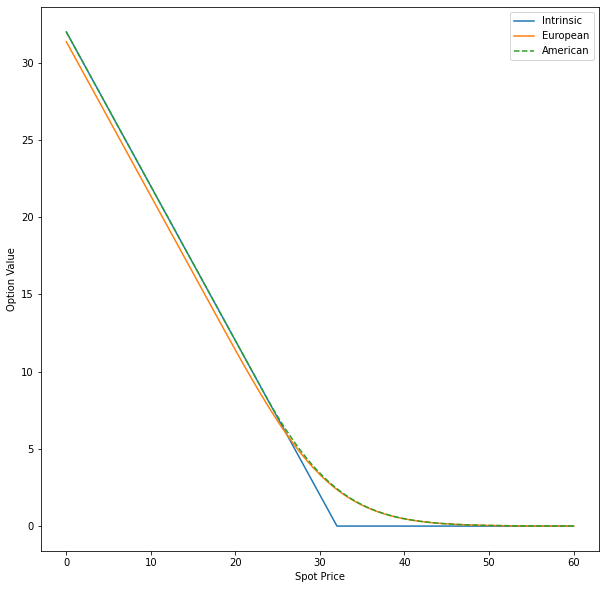

In [21]:
figure(figsize=(10,10))
plt.plot(x,putValue(s_0=x,K=32), label="Intrinsic")
plt.plot(x,y_euc, label="European")
plt.plot(x,y_amc, label="American", ls="--")
plt.legend()
plt.xlabel("Spot Price")
plt.ylabel("Option Value")
plt.savefig("puts.png")
plt.show()

In [22]:
x = np.linspace(0.00000000001,60,1000)

In [23]:
y_eup = [BinomialLROption(i, 32, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=False).price() for i in x]

In [24]:
y_amp = [BinomialLROption(i, 32, r=0.04, T=0.5, N=1008, sigma=0.3, is_put=False, is_am=True).price() for i in x]

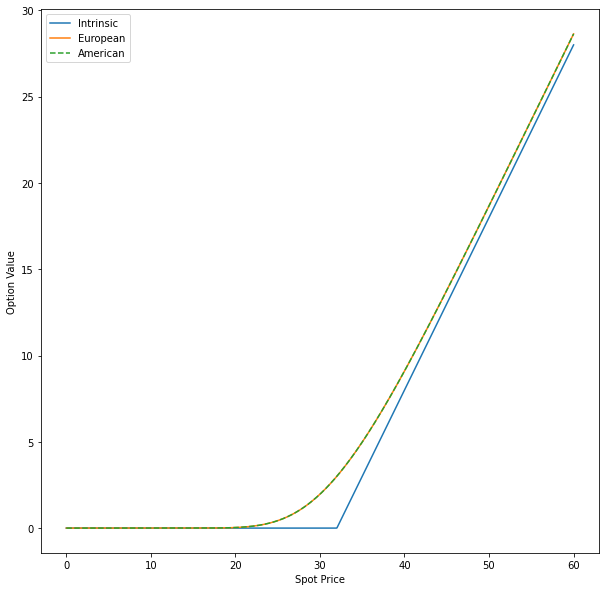

In [25]:
figure(figsize=(10,10))
plt.plot(x,callValue(s_0=x,K=32), label="Intrinsic")
plt.plot(x,y_eup, label="European")
plt.plot(x,y_amp, label="American", ls="--")
plt.legend()
plt.xlabel("Spot Price")
plt.ylabel("Option Value")
plt.savefig("calls.png")
plt.show()

# NEW STUFF FOR PART 2 FROM HERE ONWARD

# Trinomial Trees

In [68]:
class TrinomialTreeOption(BinomialTreeOption):

    def setup_parameters(self):
        self.u = math.exp(self.sigma*math.sqrt(2.*self.dt))
        self.d = 1/self.u
        self.m = 1
        self.qu = ((math.exp((self.r-self.div) * self.dt/2.) - math.exp(-self.sigma * math.sqrt(self.dt/2.))) /
                   (math.exp(self.sigma * math.sqrt(self.dt/2.)) - math.exp(-self.sigma * math.sqrt(self.dt/2.))))**2
        self.qd = ((math.exp(self.sigma * math.sqrt(self.dt/2.)) - math.exp((self.r-self.div) * self.dt/2.)) /
                   (math.exp(self.sigma * math.sqrt(self.dt/2.)) - math.exp(-self.sigma * math.sqrt(self.dt/2.))))**2
        self.qm = 1 - self.qu - self.qd

    def init_underlying_price_tree(self):
        # Initialize a 2D tree to add to
        self.STs = [np.array([self.s_0])]

        for i in range(self.N):
            prev_nodes = self.STs[-1]
            self.ST = np.concatenate((prev_nodes * self.u, [prev_nodes[-1] * self.m, prev_nodes[-1] * self.d]))
            self.STs.append(self.ST)

    def calculate_payoffs(self, payoffs):
        # Traverse the tree backwards 
        for i in reversed(range(self.N)):
            payoffs = (payoffs[:-2] * self.qu + payoffs[1:-1] * self.qm + payoffs[2:] * self.qd) * self.df

            if not self.is_european:
                payoffs = self.check_early_exercise(payoffs, i)

        return payoffs

In [69]:
eu_put = TrinomialTreeOption(50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True)

In [70]:
print('European put:', eu_put.price())

European put: 6.573565269142496


In [40]:
am_option = TrinomialTreeOption(50, 52, r=0.05, T=2, N=2, sigma=0.3, is_put=True, is_am=True)

In [41]:
print('American put:', am_option.price())

American put: 7.161349217272585


## Generating a table of trinomial option prices

In [72]:
prices = [10, 30, 50, 70, 90]
is_put = [False, True]
is_am = [False, True]

In [103]:
import pandas as pd

rows_list = []
for style in is_am:
    for opt_type in is_put:
        row = {}
        row['is_am']=style
        row['is_put']=opt_type
        for price in prices:
            col = str(price)
            row[col] = BinomialCRROption(price, 52, r=0.04, T=0.5, N=6, sigma=1, is_put=opt_type, is_am=style).price()
        rows_list.append(row)
        
        
opt_prices = pd.DataFrame(rows_list)

In [104]:
opt_prices

,is_am,is_put,10,30,50,70,90
0,False,False,0.029635,3.225469,13.174447,28.354095,44.114929
1,False,True,40.999966,24.195800,14.144778,9.324426,5.085260
2,True,False,0.029635,3.225469,13.174447,28.354095,44.114929
3,True,True,42.000000,24.526709,14.353000,9.389724,5.150558


In [99]:
rows_list = []
for style in is_am:
    for opt_type in is_put:
        row = {}
        row['is_am']=style
        row['is_put']=opt_type
        for price in prices:
            col = str(price)
            row[col] = TrinomialTreeOption(price, 52, r=0.04, T=0.5, N=6, sigma=1, is_put=opt_type, is_am=style).price()
        rows_list.append(row)
        
        
opt_prices_tri = pd.DataFrame(rows_list)

In [100]:
opt_prices_tri

,is_am,is_put,10,30,50,70,90
0,False,False,0.031336,3.580736,13.372588,27.964310,44.674664
1,False,True,41.001667,24.551067,14.342919,8.934641,5.644995
2,True,False,0.031336,3.580736,13.372588,27.964310,44.674664
3,True,True,42.000000,24.820136,14.470768,8.990804,5.662706


In [107]:
rows_list = []
for opt_type in is_put:
    row = {}
    row['is_put']=opt_type
    for price in prices:
        col = str(price)
        row[col] = black_scholes_analytical(price, K=52, r=0.04, T=0.5, sigma=1, is_put=opt_type)
    rows_list.append(row)
        
        
opt_prices_bs = pd.DataFrame(rows_list)

In [108]:
opt_prices_bs

,is_put,10,30,50,70,90
0,False,0.055021,3.501070,13.470160,27.798794,44.538811
1,True,41.025352,24.471401,14.440491,8.769125,5.509142


In [109]:
is_tri = [False, True]
N_steps = [6, 126, 252, 1008]

In [124]:
rows_list = []
for price in prices:
    for bt in is_tri:
        row = {}
        row['price'] = price
        row['is_tri']=bt
        for N_step in N_steps:
            col = str(N_step)
            if bt:
                row[col] = TrinomialTreeOption(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, is_put=False, is_am=True).price()
            else:
                row[col] = BinomialCRROption(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, is_put=False, is_am=True).price()
        rows_list.append(row)
        
        
opt_prices_btcall = pd.DataFrame(rows_list)

In [125]:
opt_prices_btcall

,price,is_tri,6,126,252,1008
0,10,False,0.029635,0.053063,0.054643,0.054727
1,10,True,0.031336,0.054643,0.054642,0.054962
2,30,False,3.225469,3.510016,3.500052,3.502136
3,30,True,3.580736,3.500052,3.502343,3.501777
4,50,False,13.174447,13.487939,13.482459,13.469489
5,50,True,13.372588,13.482459,13.475704,13.470883
6,70,False,28.354095,27.819679,27.808485,27.801180
7,70,True,27.964310,27.808485,27.802581,27.800344
8,90,False,44.114929,44.553680,44.536355,44.540383
9,90,True,44.674664,44.536355,44.541655,44.539958


In [116]:
rows_list = []
for price in prices:
    for bt in is_tri:
        row = {}
        row['price'] = price
        row['is_tri']=bt
        for N_step in N_steps:
            col = str(N_step)
            if bt:
                row[col] = TrinomialTreeOption(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, is_put=True, is_am=True).price()
            else:
                row[col] = BinomialCRROption(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, is_put=True, is_am=True).price()
        rows_list.append(row)
        
        
opt_prices_btput = pd.DataFrame(rows_list)

In [117]:
opt_prices_btput

,price,is_tri,6,126,252,1008
0,10,False,42.000000,42.000000,42.000000,42.000000
1,10,True,42.000000,42.000000,42.000000,42.000000
2,30,False,24.526709,24.758291,24.748179,24.748545
3,30,True,24.820136,24.746953,24.748406,24.747885
4,50,False,14.353000,14.568609,14.561265,14.547684
5,50,True,14.470768,14.560277,14.553444,14.548756
6,70,False,9.389724,8.841586,8.829926,8.822249
7,70,True,8.990804,8.829221,8.823644,8.821150
8,90,False,5.150558,5.551290,5.533711,5.537317
9,90,True,5.662706,5.533219,5.538660,5.536762


# Monte Carlo Simulations

### Define European option simulator and value calculator as discussed in report

In [149]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, is_put):

    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    if is_put:
        payoff = np.maximum(0, K - S_T)
    else:
        payoff = np.maximum(0, S_T - K)
        
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

In [150]:
prices = [10, 30, 50, 70, 90]
is_put = [False, True]

In [151]:
european_option_simulation(S_0=50, K=52, T=0.5, r=0.04, sigma=1, n_sims=10000000, is_put=True)

14.43074961233692

In [152]:
rows_list = []
for opt_type in is_put:
    row = {}
    row['is_put']=opt_type
    for price in prices:
        col = str(price)
        row[col] = european_option_simulation(price, K=52, r=0.04, T=0.5, sigma=1, n_sims=1000000, is_put=opt_type)
    rows_list.append(row)
        
        
opt_prices_mc = pd.DataFrame(rows_list)

In [153]:
opt_prices_mc

,is_put,10,30,50,70,90
0,False,0.056340,3.511628,13.491865,27.853468,44.559145
1,True,41.026896,24.475749,14.447755,8.754133,5.502743


## Do the same for American option

### This time, we need the whole path of the of price of the underlying to take into account the possibility of early exercise. For this we make a support function to generate underlying paths

In [173]:
def simulate_gbm(S_0, mu, sigma,  T, N, n_sims):

    dt = T/N
    dW = np.random.normal(scale=np.sqrt(dt),size=(n_sims, N + 1))
    S_t = S_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW,axis=1))
    S_t[:, 0] = S_0

    return S_t

In [174]:
def lsmc_american_option(S_0, K, T, N, r, sigma, is_put, poly_degree, n_sims):
    
    dt = T / N
    discount_factor = np.exp(-r * dt)

    gbm_simulations = simulate_gbm(S_0=S_0, mu=r, sigma=sigma, n_sims=n_sims, T=T, N=N,)

    if is_put:
        payoff_matrix = np.maximum(K - gbm_simulations, np.zeros_like(gbm_simulations))
    else:
        payoff_matrix = np.maximum(gbm_simulations - K, np.zeros_like(gbm_simulations))
    
    value_matrix = np.zeros_like(payoff_matrix)
    value_matrix[:, -1] = payoff_matrix[:, -1]

    for t in range(N - 1, 0, -1):
        regression = np.polyfit(gbm_simulations[:, t], value_matrix[:, t + 1] * discount_factor, poly_degree)
        continuation_value = np.polyval(regression, gbm_simulations[:, t])
        value_matrix[:, t] = np.where(payoff_matrix[:, t] > continuation_value, payoff_matrix[:, t], value_matrix[:, t + 1] * discount_factor)

    option_premium = np.mean(value_matrix[:, 1] * discount_factor)
    return option_premium

In [197]:
# N_SIMS 10000 takes a handful of seconds, N_SIMS 100000 takes a few minutes, N_SIMS 1000000 takes more than two hours
N_SIMS = 100000
N_steps = [6, 126, 252, 1008]
prices = [10, 30, 50, 70, 90]

In [198]:
rows_list = []
for price in prices:
    row = {}
    row['price'] = price
    for N_step in N_steps:
        col = str(N_step)
        row[col] = lsmc_american_option(price, 52, r=0.04, T=0.5, N=N_step, sigma=1, poly_degree=5, n_sims=N_SIMS, is_put=True)
    
    rows_list.append(row)
        
        
opt_prices_lsmc = pd.DataFrame(rows_list)

In [199]:
opt_prices_lsmc

,price,6,126,252,1008
0,10,41.818603,41.987142,41.991629,41.998628
1,30,25.308526,24.627541,24.534923,24.513859
2,50,15.475367,14.235831,14.181039,14.129088
3,70,9.777543,8.423499,8.324311,8.213723
4,90,6.308202,4.987168,4.908039,4.747664


In [200]:
opt_prices_lsmc_put_100000 = opt_prices_lsmc

In [196]:
opt_prices_lsmc_call_100000

,price,6,126,252,1008
0,10,0.092051,0.029006,0.029035,0.036475
1,30,4.110022,3.278732,3.230613,3.199812
2,50,14.428258,13.084880,13.182150,12.798266
3,70,28.945112,27.387203,27.399228,27.067871
4,90,45.732476,43.969425,43.988972,43.487231


In [201]:
opt_prices_lsmc_put_100000

,price,6,126,252,1008
0,10,41.818603,41.987142,41.991629,41.998628
1,30,25.308526,24.627541,24.534923,24.513859
2,50,15.475367,14.235831,14.181039,14.129088
3,70,9.777543,8.423499,8.324311,8.213723
4,90,6.308202,4.987168,4.908039,4.747664
